cuda
Epoch 1/20
Train Loss: 2.0591, Train Accuracy: 0.250
Test Loss: 1.7886, Test Accuracy: 0.370
Epoch 2/20
Train Loss: 1.1735, Train Accuracy: 0.602
Test Loss: 1.1378, Test Accuracy: 0.647
Epoch 3/20
Train Loss: 0.5604, Train Accuracy: 0.826
Test Loss: 1.2556, Test Accuracy: 0.677
Epoch 4/20
Train Loss: 0.3597, Train Accuracy: 0.894
Test Loss: 0.9015, Test Accuracy: 0.740
Epoch 5/20
Train Loss: 0.2598, Train Accuracy: 0.923
Test Loss: 1.0826, Test Accuracy: 0.728
Epoch 6/20
Train Loss: 0.1974, Train Accuracy: 0.939
Test Loss: 0.9067, Test Accuracy: 0.758
Epoch 7/20
Train Loss: 0.1403, Train Accuracy: 0.957
Test Loss: 1.1329, Test Accuracy: 0.740
Early stopping triggered: Validation loss increased significantly (1.1329 > 1.1015).
Time: 17.373 seconds


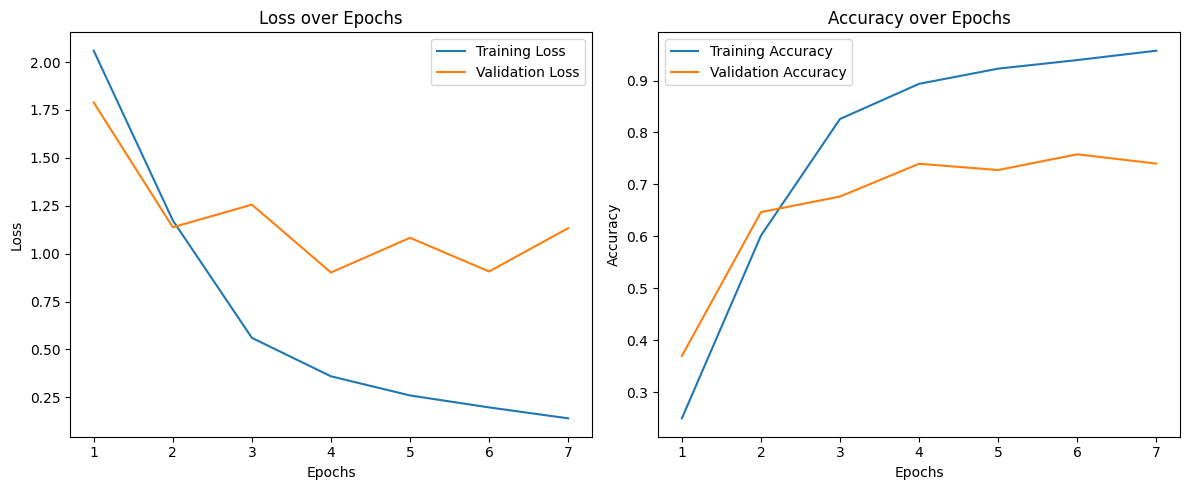

Gradient Norm of conv1.weight: 0.3873423635959625
Gradient Norm of conv1.bias: 4.077355981735309e-07
Gradient Norm of bn1.weight: 0.05824035778641701
Gradient Norm of bn1.bias: 0.03516504541039467
Gradient Norm of conv2.weight: 1.488203525543213
Gradient Norm of conv2.bias: 1.4172459650296787e-08
Gradient Norm of bn2.weight: 0.0419839546084404
Gradient Norm of bn2.bias: 0.030124522745609283
Gradient Norm of conv3.weight: 1.4094631671905518
Gradient Norm of conv3.bias: 1.1740753258493442e-08
Gradient Norm of bn3.weight: 0.050312917679548264
Gradient Norm of bn3.bias: 0.040448930114507675
Gradient Norm of conv4.weight: 0.8553324341773987
Gradient Norm of conv4.bias: 4.598497138630364e-09
Gradient Norm of bn4.weight: 0.028678344562649727
Gradient Norm of bn4.bias: 0.015310254879295826
Gradient Norm of fc1.weight: 0.4057503938674927
Gradient Norm of fc1.bias: 0.008194305002689362
Gradient Norm of fc2.weight: 0.3395649790763855
Gradient Norm of fc2.bias: 0.008883757516741753
Gradient Norm o

In [4]:
 import time
 import numpy as np
 import torch
 import torch.nn as nn
 import torch.nn.functional as F
 import torch.optim as optim
 from torch.utils.data import TensorDataset, DataLoader
 import matplotlib.pyplot as plt
 # Prepare dataset
 def prepareData(file_name):
     train_data = np.loadtxt(file_name, delimiter=',')
     train_data = np.loadtxt(file_name, delimiter=',')
     y = train_data[:, 0]
     X = train_data[:, 1:] / 255.
     # Reshape input data for single-channel images (28x84)
     X = X.reshape(-1, 1, 28, 84)  # 1 channel, size 28x84
     # Convert to PyTorch Tensors
     tensor_X = torch.Tensor(X)
     tensor_y = torch.LongTensor(y)
     dataset = TensorDataset(tensor_X, tensor_y)  # create PyTorch TensorDataset
     dataloader = DataLoader(dataset, batch_size=32, shuffle=True)  # create PyTorch DataLoader
     return dataset, dataloader
 train_dataset, train_dataloader = prepareData('sample_data/A4train.csv')
 test_dataset, test_dataloader = prepareData('sample_data/A4val.csv')
 # Define CNN model
 class Net(nn.Module):
     def __init__(self):
         super(Net, self).__init__()
         # Convolutional layers
         self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # input: 1 channel
         self.bn1 = nn.BatchNorm2d(32)
         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
         self.bn2 = nn.BatchNorm2d(64)
         self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
         self.bn3 = nn.BatchNorm2d(128)
         self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
         self.bn4 = nn.BatchNorm2d(256)
         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # pooling layer

         # Fully connected layers
         self.fc1 = nn.Linear(256 * 1 * 5, 512)  # updated dimensions after pooling
         self.fc2 = nn.Linear(512, 256)
         self.fc3 = nn.Linear(256, 128)
         self.fc4 = nn.Linear(128, 10)  # output layer for 10 classes
         self.dropout = nn.Dropout(0.3)  # dropout for regularization

     def forward(self, x):
         x = self.conv1(x)
         x = self.bn1(x)
         x = F.relu(x)
         x = self.pool(x)
         x = self.conv2(x)
         x = self.bn2(x)
         x = F.relu(x)
         x = self.pool(x)
         x = self.conv3(x)
         x = self.bn3(x)
         x = F.relu(x)
         x = self.pool(x)
         x = self.conv4(x)
         x = self.bn4(x)
         x = F.relu(x)
         x = self.pool(x)
         x = x.view(x.size(0), -1)  # flatten the tensor for the fully connected layers
         x = self.fc1(x)
         x = F.relu(x)
         x = self.dropout(x)
         x = self.fc2(x)
         x = F.relu(x)
         x = self.dropout(x)
         x = self.fc3(x)
         x = F.relu(x)
         x = self.dropout(x)
         x = self.fc4(x)
         output = F.log_softmax(x, dim=1)  # softmax for multi-class classification
         return output

 # Device
 device = "cuda" if torch.cuda.is_available() else "cpu"
 print(device)
 model = Net().to(device)  # use proper device
 # Optimizer: Adam
 optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

 # Training loop
 def train(model, optimizer, train_dataloader, device):
     model.train()  # entering training mode (dropout behaves differently)
     train_loss = 0
     correct = 0
     for data, target in train_dataloader:
         data, target = data.to(device), target.to(device)  # move data to the same device
         optimizer.zero_grad()  # clear existing gradients
         output = model(data)  # forward pass
         loss = F.nll_loss(output, target)  # compute the loss
         loss.backward()  # backward pass: calculate the gradients
         optimizer.step()  # take a gradient step
         train_loss += loss.item() * data.size(0)
         pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
         correct += pred.eq(target.view_as(pred)).sum().item()
     train_loss /= len(train_dataloader.dataset)
     accuracy = correct / len(train_dataloader.dataset)
     return train_loss, accuracy
 # Test loop
 def test(model, test_dataloader, device):
     model.eval()  # entering evaluation mode (dropout behaves differently)
     test_loss = 0
     correct = 0
     with torch.no_grad():  # do not compute gradient
         for data, target in test_dataloader:
             data, target = data.to(device), target.to(device)
             output = model(data)
             test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
             pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
             correct += pred.eq(target.view_as(pred)).sum().item()
     test_loss /= len(test_dataloader.dataset)
     accuracy = correct / len(test_dataloader.dataset)
     return test_loss, accuracy
 # Training with early stopping
 n_epochs = 20
 train_losses, train_accuracies = [], []
 test_losses, test_accuracies = [], []
 start_time = time.time()
 early_stop_threshold = 0.20  # Threshold for loss increase
 best_test_loss = float('inf')  # Initialize the best loss to infinity
 early_stop_triggered = False
 scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
 for epoch in range(n_epochs):

     train_loss, train_acc = train(model, optimizer, train_dataloader, device)
     test_loss, test_acc = test(model, test_dataloader, device)
     scheduler.step(test_loss)  # Adjust learning rate based on validation loss
     train_losses.append(train_loss)
     train_accuracies.append(train_acc)
     test_losses.append(test_loss)
     test_accuracies.append(test_acc)
     print(f"Epoch {epoch + 1}/{n_epochs}")
     print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.3f}")
     print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.3f}")
     # Check for significant increase in validation loss
     if test_loss > best_test_loss + early_stop_threshold:
         print(f"Early stopping triggered: Validation loss increased significantly ({test_loss:.4f} > {best_test_loss + early_stop_threshold:.4f}).")
         early_stop_triggered = True
         break
     # Update the best test loss
     best_test_loss = min(best_test_loss, test_loss)
 if not early_stop_triggered:
     print("Training completed without early stopping.")
 print(f"Time: {time.time() - start_time:.3f} seconds")
 # Visualization of training and validation metrics
 epochs = range(1, len(train_losses) + 1)
 plt.figure(figsize=(12, 5))
 # Plot loss
 plt.subplot(1, 2, 1)
 plt.plot(epochs, train_losses, label='Training Loss')
 plt.plot(epochs, test_losses, label='Validation Loss')
 plt.title('Loss over Epochs')
 plt.xlabel('Epochs')
 plt.ylabel('Loss')
 plt.legend()
 # Plot accuracy
 plt.subplot(1, 2, 2)
 plt.plot(epochs, train_accuracies, label='Training Accuracy')
 plt.plot(epochs, test_accuracies, label='Validation Accuracy')
 plt.title('Accuracy over Epochs')
 plt.xlabel('Epochs')
 plt.ylabel('Accuracy')
 plt.legend()
 plt.tight_layout()
 plt.show()
 for name, param in model.named_parameters():
     if param.grad is not None:
         print(f"Gradient Norm of {name}: {param.grad.norm()}")